In [2]:
from stgcn import STGCN
from utils import generate_dataset, load_metr_la_data, get_normalized_adj
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import os
import pickle as pk

from shapely.geometry import Point
import matplotlib.pyplot as plt

import geopandas as gpd
# import numpy as np
# from datetime import datetime
from geopy.distance import distance
from pathlib import Path

## Preprocessing

In [3]:
data_directory = Path("../../station_5min_2022")

In [4]:
metadata_filepath = Path('../../station_5min_2022/d03_text_meta_2022_03_17.txt')
metadata = pd.read_csv(metadata_filepath, delimiter="\t")
LATITUDE_MIN = metadata["Latitude"].min()
LATITUDE_MAX = metadata["Latitude"].max()
LONGTITUDE_MIN = metadata["Longitude"].min()
LONGTITUDE_MAX = metadata["Longitude"].min()
#weekdays in one month
# days1 = [1,4,5,6,7,8] #<10
# days2 = [11,12,13,14,15,18,19,20,21,22,25,26,27,28,29] #>=10

In [5]:
# creating a geometry column
geometry = [Point(xy) for xy in zip(metadata['Longitude'], metadata['Latitude'])]
# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}
# Creating a Geographic data frame
geographic_metadata = gpd.GeoDataFrame(metadata, crs=crs, geometry=geometry)

#set plot parameters
plt.rcParams['figure.figsize'] = (12.0, 12.0)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 72

/home/shahula/bin/miniconda3/envs/pygeo/lib/python3.7/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


Text(0.5, 1.0, 'Original District 8 Station')

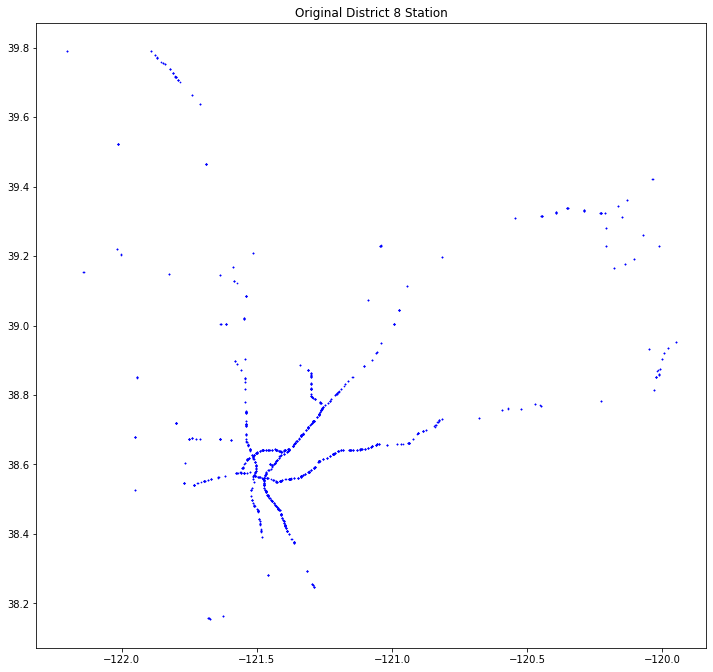

In [6]:
#plot original station
fig1, ax1 = plt.subplots(1, 1)
geographic_metadata.plot(ax=ax1, marker='o', color='b', markersize=0.5)
ax1.set_title('Original District 8 Station')

In [7]:
coordinate = [xy for xy in zip(geographic_metadata['Latitude'], geographic_metadata['Longitude'])]
geographic_metadata['coordinate'] = coordinate

In [8]:
for x, y in coordinate:
    print(f"{x}, {y}")

38.761062, -120.569835
38.761182, -120.569866
38.409782, -121.48412
38.409782, -121.48412
38.412779, -121.484363
38.428258, -121.487578
38.424648, -121.486808
38.566906, -121.505888
38.566911, -121.505906
38.564153, -121.495585
38.564153, -121.495585
38.564153, -121.495585
38.563816, -121.493316
38.563816, -121.493316
38.563816, -121.493316
38.55902, -121.476106
38.55902, -121.476106
38.560995, -121.462999
38.560995, -121.462999
38.560995, -121.462999
38.559248, -121.476019
38.409782, -121.48412
38.428229, -121.487572
38.412421, -121.484289
38.562537, -121.489577
38.562537, -121.489577
38.562774, -121.48948
38.551104, -121.429758
38.551202, -121.430183
38.552893, -121.413693
38.553566, -121.41058
38.552718, -121.414475
38.560891, -121.459539
38.560891, -121.459539
38.468819, -121.416935
38.553882, -121.437973
38.554652, -121.439488
38.558665, -121.381217
38.558665, -121.381217
38.632748, -121.502715
38.632724, -121.502762
38.633055, -121.501501
38.63316, -121.501301
38.632213, -121.503

In [9]:
days1 = [1] #<10
days2 = [2] #>=10

data_2022 = pd.DataFrame()
for day_data in sorted((data_directory).glob("d03_text_station_5min_2022_01*")):
    print(day_data)
    day_data = pd.read_csv(day_data,sep=',', header=None)
    data_2022 = pd.concat([data_2022, day_data])

../../station_5min_2022/d03_text_station_5min_2022_01_01.txt
../../station_5min_2022/d03_text_station_5min_2022_01_02.txt
../../station_5min_2022/d03_text_station_5min_2022_01_03.txt
../../station_5min_2022/d03_text_station_5min_2022_01_04.txt
../../station_5min_2022/d03_text_station_5min_2022_01_05.txt
../../station_5min_2022/d03_text_station_5min_2022_01_06.txt
../../station_5min_2022/d03_text_station_5min_2022_01_07.txt
../../station_5min_2022/d03_text_station_5min_2022_01_08.txt
../../station_5min_2022/d03_text_station_5min_2022_01_09.txt
../../station_5min_2022/d03_text_station_5min_2022_01_10.txt
../../station_5min_2022/d03_text_station_5min_2022_01_11.txt
../../station_5min_2022/d03_text_station_5min_2022_01_12.txt
../../station_5min_2022/d03_text_station_5min_2022_01_13.txt
../../station_5min_2022/d03_text_station_5min_2022_01_14.txt
../../station_5min_2022/d03_text_station_5min_2022_01_15.txt
../../station_5min_2022/d03_text_station_5min_2022_01_16.txt
../../station_5min_2022/

In [10]:
data_2022 = data_2022.rename(columns={0:'Timestamp', 1:'Station', 2:'District', 3:'Freeway', 4:'Direction', 5:'Lane_Type', 6:'Length', 7:'Samples_1', 8:'%Pbserved', 9:'TotalFlow', 10:'AvgOccu', 11:'AvgSpeed', 12:'LaneNSamples', 13:'LaneNFlow', 14:'LaneNAvgOccu', 15:'LaneNAvgSpeed', 16:'LaneNobserved'})
data_2022_filtered = data_2022.dropna(subset=['AvgSpeed'])
data_2022_processed = data_2022_filtered[['Timestamp','Station','TotalFlow','AvgOccu','AvgSpeed']]

In [11]:
#time convert
date = pd.to_datetime(data_2022_processed['Timestamp'])
data_2022_processed['Hour'] = date.dt.hour
data_2022_processed['Weekday'] = date.dt.weekday
data_2022_processed['Minute'] = date.dt.minute
data_2022_processed['Second'] = date.dt.second
data_2022_processed['Day'] = date.dt.day
data_2022_processed['Month'] = date.dt.month
data_2022_processed['Year'] = date.dt.year
data_2022_processed.to_csv('data_2022_processed.csv', index=False)

/home/shahula/bin/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/shahula/bin/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/home/shahula/bin/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:

In [12]:
# Keep only weekdays
data_2022_processed = data_2022_processed[data_2022_processed["Weekday"] < 5]

In [13]:
len(data_2022_processed['Station'].unique())

943

In [14]:
geographic_metadata.dropna(axis=0, subset=["Latitude"], inplace=True)
common_stations = np.intersect1d(data_2022_processed['Station'].unique(), geographic_metadata['ID'].unique())
common_index = data_2022_processed['Station'].isin(common_stations)
data_2022_processed = data_2022_processed[common_index]

In [15]:
# subStationGeo = gdf[(stationGeo['Latitude']>LATITUDE_MIN)
#                    & (stationGeo['Latitude']<LATITUDE_MAX)
#                    & (stationGeo['Longitude']>LONGTITUDE_MIN)
#                    & (stationGeo['Longitude']<LONGTITUDE_MAX)]
# subStationGeo = subStationGeo[['ID','geometry','geovalue']]

#part of data is missing in some station
num_timepoints = len(data_2022_processed.Timestamp.unique())
geographic_metadata_filtered = geographic_metadata.copy()
for id_number in geographic_metadata['ID']:
    if (data_2022_processed['Station']==id_number).sum() != num_timepoints:
        bad_station_indices = geographic_metadata_filtered[geographic_metadata_filtered['ID']==id_number].index
        geographic_metadata_filtered = geographic_metadata_filtered.drop(bad_station_indices, axis=0)

In [16]:
geographic_metadata_filtered[["Latitude", "Longitude"]]

,Latitude,Longitude
0,38.761062,-120.569835
1,38.761182,-120.569866
7,38.566906,-121.505888
10,38.564153,-121.495585
12,38.563816,-121.493316
...,...,...
1500,39.229936,-121.042208
1505,38.896863,-121.582147
1508,38.678651,-121.951843
1511,38.678651,-121.951843


In [17]:
common_stations = np.intersect1d(data_2022_processed['Station'].unique(), geographic_metadata_filtered['ID'].unique())
common_index = data_2022_processed['Station'].isin(common_stations)
data_2022_processed = data_2022_processed[common_index]

In [18]:
len(data_2022_processed)

5679072

In [19]:
print(num_timepoints / (24*12))

21.0


In [20]:
geographic_metadata[geographic_metadata["ID"] == 3415041]

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,Length,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,geometry,coordinate


In [21]:
# #sample 200, to reduce computation cost
# num_samples = 10000
# num_stations = len(geographic_metadata_filtered)
# geographic_metadata_sampled = geographic_metadata_filtered.sample(frac = num_samples / num_stations)

In [22]:
geographic_metadata_filtered = geographic_metadata_filtered.sort_values(by=["ID"])
num_stations = len(geographic_metadata_filtered['ID'])
point = geographic_metadata_filtered['coordinate'].tolist()
distances = []
D = np.zeros((num_stations, num_stations))
for i in range(num_stations):
    print(i)
    for j in range(i, num_stations):
        d = distance(point[i], point[j]).m
        D[i, j] = d
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [23]:
D[np.tril_indices(num_stations)] = D.T[np.tril_indices(num_stations)]

In [24]:
# D = np.array(distances).reshape(num_stations, num_stations)
def get_weighted_distances(D):
    sigma_threshold = 10000
    epsilon_threshold = 1e-5
    weighted_D = np.exp(-(D/sigma_threshold)**2)
    weighted_D[weighted_D<epsilon_threshold] = 0
    
    return weighted_D
weighted_D = get_weighted_distances(D)

In [25]:
weighted_D = weighted_D.astype(np.float32)

In [26]:
sorted_data_2022 = data_2022_processed.sort_values(by=["Station", "Timestamp"])

In [27]:
sorted_data_2022[["TotalFlow", "AvgSpeed"]]

,TotalFlow,AvgSpeed
0,40.0,63.8
1454,40.0,63.9
2908,38.0,63.9
4362,38.0,63.6
5816,41.0,63.7
...,...,...
413172,18.0,66.1
414628,17.0,64.6
416083,18.0,65.3
417538,20.0,65.7


In [28]:
formatted_data_2022 = sorted_data_2022[["TotalFlow", "AvgSpeed"]].values.reshape((num_timepoints, num_stations, 2))

In [29]:
num_subset_timepoints = 6000

subset_stations = np.full(num_stations, False)
random_stations = np.random.choice(np.arange(num_stations), size=num_stations//2)
subset_stations[random_stations] = True

In [30]:
X = formatted_data_2022.transpose((1, 2, 0))[subset_stations, :, :num_subset_timepoints].astype(np.float32)
nonX = formatted_data_2022.transpose((1, 2, 0))[~subset_stations, :, :num_subset_timepoints].astype(np.float32)
subset_weighted_D = weighted_D[subset_stations, :][:,subset_stations]
nonsubset_weighted_D = weighted_D[~subset_stations, :][:, ~subset_stations]

In [31]:
means = np.mean(X, axis=(0, 2))
X = X - means.reshape(1, -1, 1)
stds = np.std(X, axis=(0, 2))
X = X / stds.reshape(1, -1, 1)

In [32]:
nonX = nonX[:len(X)]
nonsubset_weighted_D = nonsubset_weighted_D[:len(X), :len(X)]

In [33]:
nonmeans = np.mean(nonX, axis=(0, 2))
nonX = nonX - means.reshape(1, -1, 1)
nonstds = np.std(nonX, axis=(0, 2))
nonX = nonX / stds.reshape(1, -1, 1)

<AxesSubplot:>

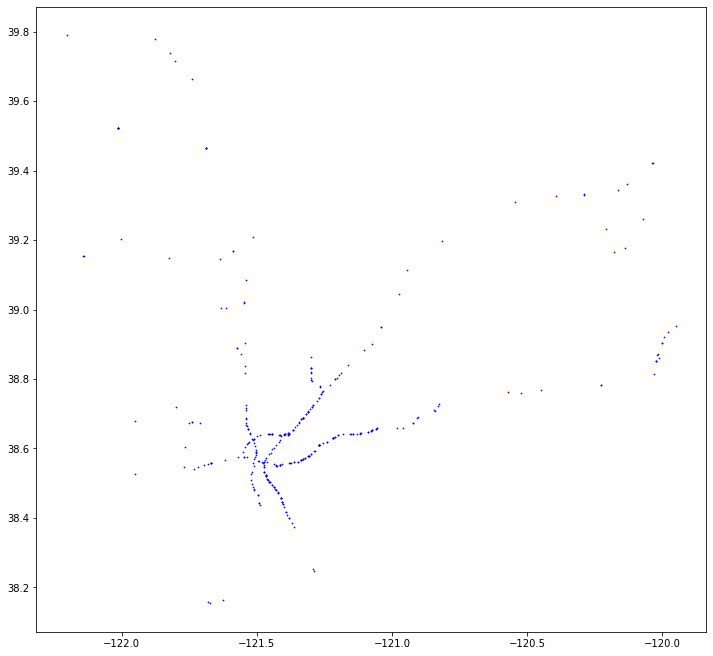

In [34]:
fig1, ax1 = plt.subplots(1, 1)
geographic_metadata_filtered.iloc[subset_stations].plot(ax=ax1, marker='o', color='b', markersize=0.5)


<AxesSubplot:>

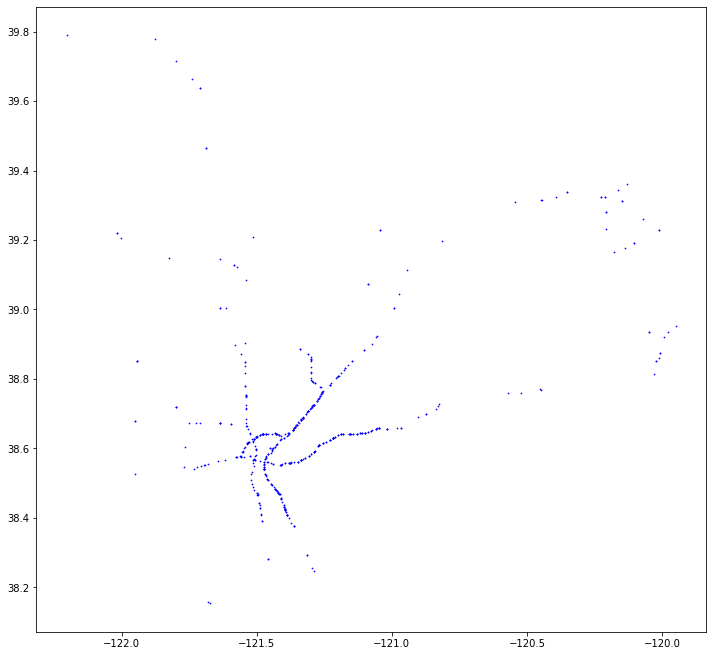

In [35]:
fig1, ax1 = plt.subplots(1, 1)
geographic_metadata_filtered.iloc[~subset_stations].plot(ax=ax1, marker='o', color='b', markersize=0.5)

In [36]:
D

array([[0.00000000e+00, 1.35910727e+01, 8.42713563e+04, ...,
        1.20535541e+05, 1.20535541e+05, 1.20535541e+05],
       [1.35910727e+01, 0.00000000e+00, 8.42720902e+04, ...,
        1.20533765e+05, 1.20533765e+05, 1.20533765e+05],
       [8.42713563e+04, 8.42720902e+04, 0.00000000e+00, ...,
        4.07686972e+04, 4.07686972e+04, 4.07686972e+04],
       ...,
       [1.20535541e+05, 1.20533765e+05, 4.07686972e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.20535541e+05, 1.20533765e+05, 4.07686972e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.20535541e+05, 1.20533765e+05, 4.07686972e+04, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

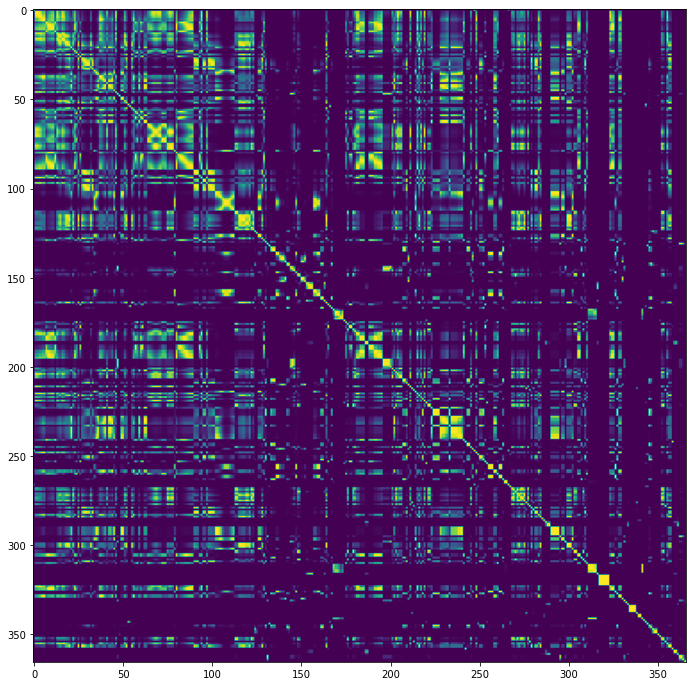

In [37]:
fig = plt.figure()
colorbar_ax = plt.imshow(subset_weighted_D)
fig.colorbar(colorbar_ax, ax=ax1)

## Training STGCN

In [192]:
t = torch.cuda.get_device_properties(0).total_memory
r = torch.cuda.memory_reserved(0)
a = torch.cuda.memory_allocated(0)
f = r-a  # free inside reserved
f / 1e6

0.0

In [193]:
torch.manual_seed(7)
device = "cuda:1"
num_timesteps_input = 12
num_timesteps_output = 3

epochs = 500
batch_size = 50

In [194]:
from importlib import reload

In [255]:
import stgcn
reload(stgcn)
import imputation
reload(imputation)
from stgcn import STGCN
from imputation import ImputationalSTGCN

In [256]:
def train_epoch(training_input, training_target, batch_size):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(training_input.shape[0])

    epoch_training_losses = []
    for i in range(0, training_input.shape[0], batch_size):
        net.train()
        optimizer.zero_grad()

        indices = permutation[i:i + batch_size]
        X_batch, y_batch = training_input[indices], training_target[indices]
        X_batch = X_batch.to(device=device)
        y_batch = y_batch.to(device=device)

        out = net(A_wave, X_batch)
        loss = loss_criterion(out, y_batch)
        loss.backward()
        optimizer.step()
        epoch_training_losses.append(loss.detach().cpu().numpy())
    return sum(epoch_training_losses)/len(epoch_training_losses)

In [257]:
def imputation_loss(y_batch, out_complete, complete_attn_weights, out_incomplete,
                    incomplete_attn_weights, loss_criterion):
    """Compute loss for complete and incomplete datsets.
    
    """
        y_batch_incomplete = torch.einsum('bct,bic->bit', [y_batch, incomplete_attn_weights])
        y_batch_complete = torch.einsum('bct,bic->bit', [y_batch, complete_attn_weights])

#         print(f"incomplete_attn_weights: {incomplete_attn_weights[0]}")
#         print(f"complete_attn_weights: {complete_attn_weights[0]}")
        
#         print(f"y_batch: {y_batch[0]}")
#         print(f"y_batch_complete: {y_batch_complete[0]}")
#         print(f"y_batch_incomplete: {y_batch_incomplete[0]}")
        loss_complete = loss_criterion(out_complete, y_batch)
#         print(f"loss_complete: {loss_complete}")
        loss_incomplete = loss_criterion(out_incomplete, y_batch_incomplete)
#         print(f"loss_incomplete: {loss_incomplete}")
        loss_consistency = loss_criterion(y_batch, y_batch_complete)
#         print(f"loss_consistency: {loss_consistency}")
#         loss = loss_complete + loss_incomplete + loss_consistency
        
        return (loss_complete, loss_incomplete, loss_consistency)

In [266]:
def test_epoch(test_input, test_target, A_wave, batch_size, loss_criterion, ):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(test_input.shape[0])

    epoch_training_losses = []
    for i in range(0, test_input.shape[0], batch_size):
        net.eval()

        indices = permutation[i:i + batch_size]
        X_batch, y_batch = test_input[indices], test_target[indices]
        X_batch = X_batch.to(device=device)
        y_batch = y_batch.to(device=device)

        with torch.no_grad():
            out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, X_batch)
            loss_complete, loss_incomplete, loss_consistency = imputation_loss(y_batch, out_complete, complete_attn_weights,
                                   out_incomplete, incomplete_attn_weights, loss_criterion)
            loss = loss_complete + loss_incomplete

        epoch_training_losses.append(loss.detach().cpu().numpy())
        
    return sum(epoch_training_losses)/len(epoch_training_losses)

In [267]:
def train_epoch_with_imputation(training_input, training_target, batch_size, optimizer, loss_criterion):
    """
    Trains one epoch with the given data.
    :param training_input: Training inputs of shape (num_samples, num_nodes,
    num_timesteps_train, num_features).
    :param training_target: Training targets of shape (num_samples, num_nodes,
    num_timesteps_predict).
    :param batch_size: Batch size to use during training.
    :return: Average loss for this epoch.
    """
    permutation = torch.randperm(training_input.shape[0])

    epoch_training_losses = []
    with torch.autograd.set_detect_anomaly(True):
        for i in range(0, training_input.shape[0], batch_size):
            net.train()
            optimizer.zero_grad()

            indices = permutation[i:i + batch_size]
            X_batch, y_batch = training_input[indices], training_target[indices]
            X_batch = X_batch.to(device=device)
            y_batch = y_batch.to(device=device)

            out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, X_batch)

            loss_complete, loss_incomplete, loss_consistency = imputation_loss(y_batch, out_complete, complete_attn_weights,
                                   out_incomplete, incomplete_attn_weights, loss_criterion)
#             print(loss)
#             2/0
    #         y_batch_incomplete = torch.einsum('bct,bic->bit', [y_batch, incomplete_attn_weights])
    #         y_batch_complete = torch.einsum('bct,bic->bit', [y_batch, complete_attn_weights])

    #         loss_complete = loss_criterion(out_complete, y_batch)
    #         loss_incomplete = loss_criterion(out_incomplete, y_batch_incomplete)
    #         loss_consistency = loss_criterion(y_batch, y_batch_complete)
    #         loss = loss_complete + loss_incomplete + loss_consistency
            loss.backward()
#             for n, p in net.weight_mapper.named_parameters():
#                 print(n, p)
#                 print(n, p.grad)

            optimizer.step()
            epoch_training_losses.append(loss.detach().cpu().numpy())
    return sum(epoch_training_losses)/len(epoch_training_losses)

In [268]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [264]:
split_line1 = int(X.shape[2] * 0.6)
split_line2 = int(X.shape[2] * 0.7)

train_original_data = X[:, :, :split_line1]
val_original_data = X[:, :, split_line1:split_line2]
test_original_data = X[:, :, split_line2:]

training_input, training_target = generate_dataset(train_original_data,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)
val_input, val_target = generate_dataset(val_original_data,
                                         num_timesteps_input=num_timesteps_input,
                                         num_timesteps_output=num_timesteps_output)
test_input, test_target = generate_dataset(test_original_data,
                                           num_timesteps_input=num_timesteps_input,
                                           num_timesteps_output=num_timesteps_output)

A_wave = get_normalized_adj(subset_weighted_D)
A_wave = torch.from_numpy(A_wave)

A_wave = A_wave.to(device=device)

net = ImputationalSTGCN(A_wave.shape[0],
            training_input.shape[3],
            num_timesteps_input,
            num_timesteps_output).to(device=device)

# with torch.no_grad():
#     val_input = val_input.to(device=device)
#     net(A_wave, val_input)
#     val_input = val_input.to(device="cpu")

# 2/0
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_criterion = nn.MSELoss()

training_losses = []
validation_losses = []
validation_maes = []
for epoch in range(epochs):
    loss = train_epoch_with_imputation(training_input, training_target,
                       batch_size=batch_size, optimizer=optimizer, loss_criterion=loss_criterion)
    training_losses.append(loss)

    # Run validation
    with torch.no_grad():
        net.eval()
        val_input = val_input.to(device=device)
        val_target = val_target.to(device=device)

        out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(A_wave, val_input)
        val_loss = imputation_loss(val_target, out_complete, complete_attn_weights,
                                   out_incomplete, incomplete_attn_weights, loss_criterion).cpu()
#         val_loss = loss_criterion(out_complete, val_target).to(device="cpu")
        validation_losses.append(np.asscalar(val_loss.detach().numpy()))

        out_unnormalized = out_complete.detach().cpu().numpy()*stds[0]+means[0]
        target_unnormalized = val_target.detach().cpu().numpy()*stds[0]+means[0]
        mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))
        validation_maes.append(mae)

        out = None
        val_input = val_input.to(device="cpu")
        val_target = val_target.to(device="cpu")

    print("Training loss: {}".format(training_losses[-1]))
    print("Validation loss: {}".format(validation_losses[-1]))
    print("Validation MAE: {}".format(validation_maes[-1]))

    checkpoint_path = "checkpoints/"
    if not os.path.exists(checkpoint_path):
        os.makedirs(checkpoint_path)
    with open("checkpoints/losses_imputation.pk", "wb") as fd:
        pk.dump((training_losses, validation_losses, validation_maes), fd)
        
plt.plot(training_losses, label="training loss")
plt.plot(validation_losses, label="validation loss")
plt.legend()
plt.show()

/home/shahula/bin/miniconda3/envs/pygeo/lib/python3.7/site-packages/ipykernel_launcher.py:55: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


Training loss: 1.4310060905085669
Validation loss: 1.0212469100952148
Validation MAE: 76.55784606933594
Training loss: 1.0949274483654234
Validation loss: 0.9767730236053467
Validation MAE: 69.16181182861328
Training loss: 1.0368288829922676
Validation loss: 0.9707898497581482
Validation MAE: 70.99747467041016
Training loss: 1.0193351440959506
Validation loss: 0.9719937443733215
Validation MAE: 71.29420471191406
Training loss: 0.9999862520231141
Validation loss: 1.0148371458053589
Validation MAE: 73.78205108642578
Training loss: 0.99196417712503
Validation loss: 0.9197494983673096
Validation MAE: 70.60877990722656
Training loss: 0.957950601975123
Validation loss: 0.9440896511077881
Validation MAE: 67.87052154541016
Training loss: 0.8781784524520239
Validation loss: 0.9643312692642212
Validation MAE: 67.79527282714844
Training loss: 0.8266492663986154
Validation loss: 0.8540183305740356
Validation MAE: 63.27169418334961
Training loss: 0.7930990300244756
Validation loss: 0.85113894939422

Training loss: 0.33545660268929267
Validation loss: 0.6171998381614685
Validation MAE: 47.37753677368164
Training loss: 0.33157641751070815
Validation loss: 0.6379234790802002
Validation MAE: 47.77312088012695
Training loss: 0.33247838148640263
Validation loss: 0.6454595327377319
Validation MAE: 48.381080627441406
Training loss: 0.3356513544503186
Validation loss: 0.6892201900482178
Validation MAE: 50.604854583740234
Training loss: 0.33030354231595993
Validation loss: 0.6822966933250427
Validation MAE: 50.492000579833984
Training loss: 0.3253187866260608
Validation loss: 0.6630045175552368
Validation MAE: 49.362911224365234
Training loss: 0.319124560803175
Validation loss: 0.6479860544204712
Validation MAE: 48.197200775146484
Training loss: 0.32469625067379737
Validation loss: 0.6946915984153748
Validation MAE: 50.88248825073242
Training loss: 0.325366233372026
Validation loss: 0.6468968391418457
Validation MAE: 48.356380462646484
Training loss: 0.33211129572656417
Validation loss: 0.6

Training loss: 0.2544734161347151
Validation loss: 0.6803615689277649
Validation MAE: 48.720706939697266
Training loss: 0.2527898076093859
Validation loss: 0.6919533014297485
Validation MAE: 49.59828186035156
Training loss: 0.25432678912248874
Validation loss: 0.6887887120246887
Validation MAE: 49.206581115722656
Training loss: 0.2592276769379775
Validation loss: 0.6967229843139648
Validation MAE: 50.03451156616211
Training loss: 0.2556922228799926
Validation loss: 0.6988072991371155
Validation MAE: 49.586360931396484
Training loss: 0.2509539286709494
Validation loss: 0.6858276128768921
Validation MAE: 49.364078521728516
Training loss: 0.2587366503559881
Validation loss: 0.6863044500350952
Validation MAE: 49.66365051269531
Training loss: 0.24886014436682066
Validation loss: 0.7374052405357361
Validation MAE: 51.866939544677734
Training loss: 0.2592630767159992
Validation loss: 0.6781798601150513
Validation MAE: 49.25520324707031
Training loss: 0.2476533411277665
Validation loss: 0.7025

KeyboardInterrupt: 

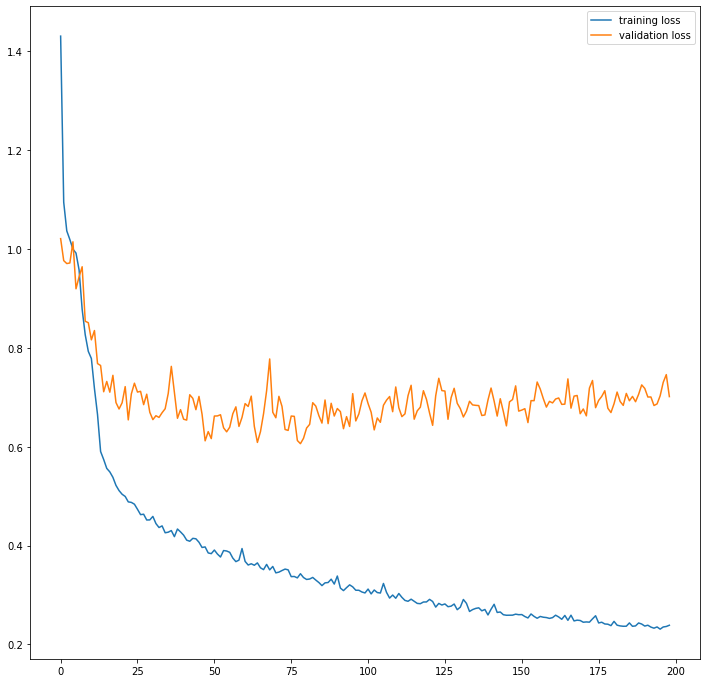

In [265]:
plt.plot(training_losses, label="training loss")
plt.plot(validation_losses, label="validation loss")
plt.legend()
plt.show()

In [269]:
test_input = test_input.to(device=device)
test_target = test_target.to(device=device)

test_loss = test_epoch(test_input, test_target, A_wave, batch_size, loss_criterion)

# out_unnormalized = out.detach().cpu().numpy()*stds[0]+means[0]
# target_unnormalized = test_target.detach().cpu().numpy()*stds[0]+means[0]
# test_mae = np.mean(np.absolute(out_unnormalized - target_unnormalized))

# out = None
# test_input = test_input.to(device="cpu")
# test_target = test_target.to(device="cpu")

print("Test loss: {}".format(test_loss))
# print("Test MAE: {}".format(test_mae))

Test loss: 0.8870315319961972


In [270]:
# split_line1 = int(nonX.shape[2] * 0.6)
# split_line2 = int(X.shape[2] * 0.8)

# train_original_data = X[:, :, :split_line1]
# val_original_data = X[:, :, split_line1:split_line2]
# test_original_data = X[:, :, split_line2:]

non_input, non_target = generate_dataset(nonX,
                                                   num_timesteps_input=num_timesteps_input,
                                                   num_timesteps_output=num_timesteps_output)

non_A_wave = get_normalized_adj(subset_weighted_D)
non_A_wave = torch.from_numpy(non_A_wave)

non_A_wave = non_A_wave.to(device=device)

In [271]:
non_loss = test_epoch(non_input, non_target, non_A_wave, batch_size, loss_criterion)
print("Non loss: {}".format(non_loss))

Non loss: 1.607157729069392


In [284]:
permutation = torch.randperm(non_input.shape[0])

net.eval()

indices = permutation[:batch_size]
X_batch, y_batch = non_input[indices], non_input[indices]
X_batch = X_batch.to(device=device)
y_batch = y_batch.to(device=device)

out_complete, complete_attn_weights, out_incomplete, incomplete_attn_weights = net(non_A_wave, X_batch)

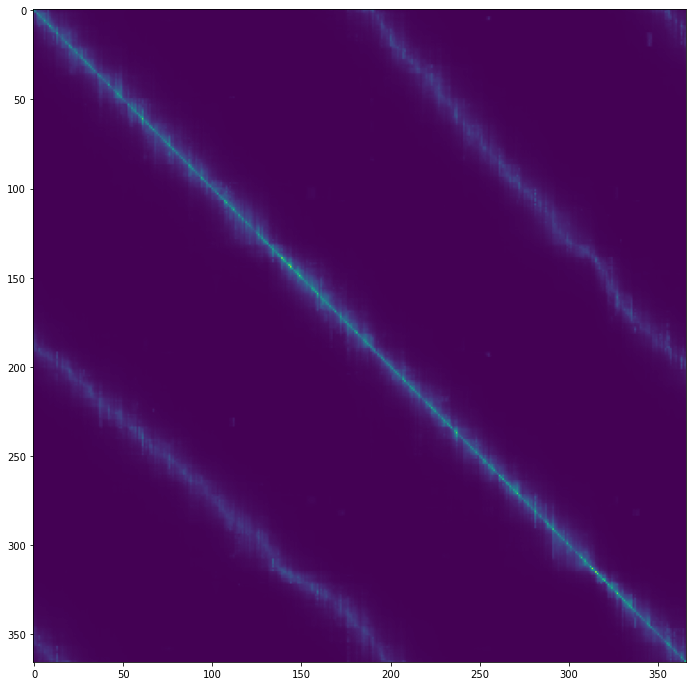

In [345]:
plt.imshow(complete_attn_weights.mean(axis=0).cpu().detach().numpy())

In [347]:
non_subset

,ID,Fwy,Dir,District,County,City,State_PM,Abs_PM,Latitude,Longitude,...,Type,Lanes,Name,User_ID_1,User_ID_2,User_ID_3,User_ID_4,geometry,coordinate,station_0
0,308511,50,E,3,17,NaN,31.627,60.162,38.761062,-120.569835,...,ML,2,Sly Park Rd,1,NaN,NaN,NaN,POINT (-120.56983 38.76106),"(38.761062, -120.569835)",0.077417
7,311903,50,E,3,67,64000.0,L0.633,3.789,38.566906,-121.505888,...,ML,3,50EB at 6TH Street,1,NaN,NaN,NaN,POINT (-121.50589 38.56691),"(38.566906, -121.505888)",0.033525
21,312132,5,S,3,67,NaN,10.896,506.189,38.409782,-121.484120,...,ML,2,Elk Grove Blvd,1,NaN,NaN,NaN,POINT (-121.48412 38.40978),"(38.409782, -121.48412)",0.023100
22,312133,5,N,3,67,NaN,12.183,507.476,38.428229,-121.487572,...,ML,3,5NB at Laguna Blvd,1,NaN,NaN,NaN,POINT (-121.48757 38.42823),"(38.428229, -121.487572)",0.021577
23,312134,5,N,3,67,NaN,11.08,506.373,38.412421,-121.484289,...,ML,2,5NB at Elk Grove Blvd,1,NaN,NaN,NaN,POINT (-121.48429 38.41242),"(38.412421, -121.484289)",0.019051
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
914,318859,99,S,3,67,64000.0,23.196,297.641,38.542193,-121.473931,...,ML,4,99SB at 12th Ave,1,NaN,NaN,NaN,POINT (-121.47393 38.54219),"(38.542193, -121.473931)",0.005225
915,318861,50,E,3,67,NaN,17.422,23.092,38.640768,-121.189423,...,HV,1,E of Zinfandel Dr,1,NaN,NaN,NaN,POINT (-121.18942 38.64077),"(38.640768, -121.189423)",0.004608
916,318863,50,W,3,67,NaN,17.422,23.092,38.640953,-121.189439,...,HV,1,E. of Zinfandel Dr,1,NaN,NaN,NaN,POINT (-121.18944 38.64095),"(38.640953, -121.189439)",0.004722
917,318869,50,W,3,67,NaN,R10.095,15.729,38.583757,-121.299476,...,HV,1,White Rock Rd,1,NaN,NaN,NaN,POINT (-121.29948 38.58376),"(38.583757, -121.299476)",0.004170


<AxesSubplot:>

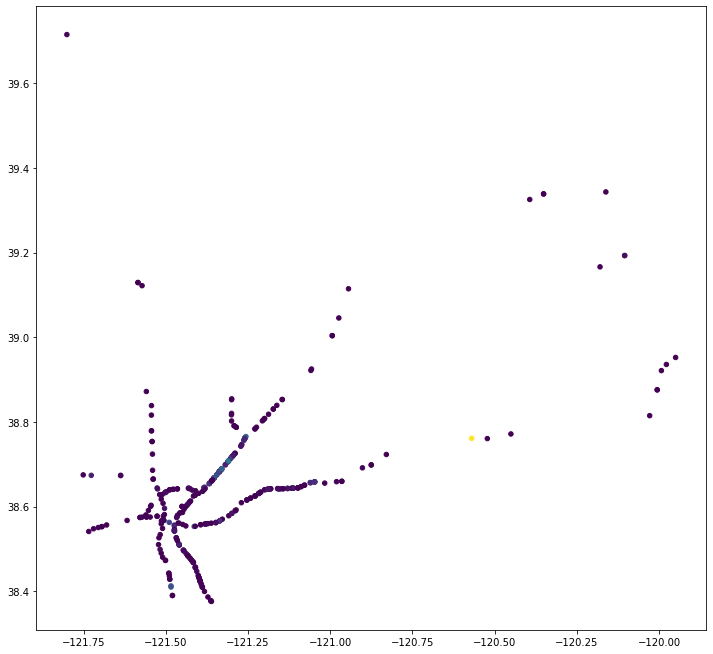

In [346]:
non_subset = geographic_metadata_filtered.iloc[~subset_stations][:len(X)]
non_subset["station_0"] = complete_attn_weights[:, 0].mean(axis=0).detach().cpu().numpy()
fig, ax1=plt.subplots()
non_subset.plot(ax=ax1, column="station_0", marker='o', markersize=20)

In [296]:
geographic_metadata_filtered.iloc[~subset_stations].plot(ax=ax1, marker='o', color='b', markersize=0.5)

<AxesSubplot:>

<Figure size 864x864 with 0 Axes>